# Numerical tessellation of waterbomb cells

This NumericalTessellation technique will work with any waterbomb cell with 6 facets and following enumeration of the vertices indices. 
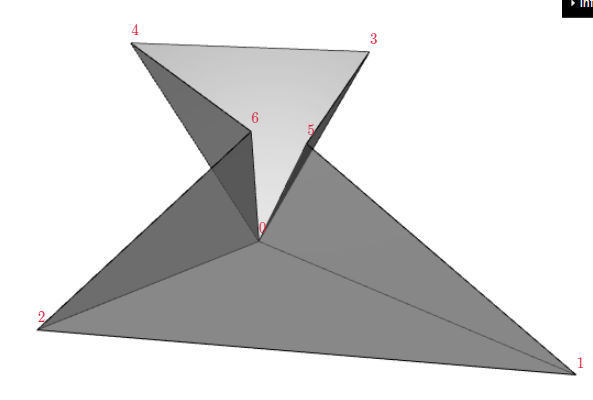

In [ ]:
%matplotlib widget
from bmcs_shell.api import WBElem5Param, WBElemSymb5ParamXL, WBNumericalTessellation, WBElem4Param, WBElem5ParamV2
import numpy as np
from numpy import sqrt, sin, cos, tan, arctan

In [ ]:
data = dict(gamma=0.2, x_ur=1400, a=1000, b=1700, c=850, show_wireframe=True)
wb = WBElem5Param(**data)
# wb.interact()

In [ ]:
import k3d
import random
def add_cell(plot, X_Ia, I_Fi):
    wb_mesh = k3d.mesh(X_Ia.astype(np.float32),
                             I_Fi.astype(np.uint32),
                            opacity=0.8,
                             color=0x999999,
                             side='double')
    rand_color = random.randint(0, 0xFFFFFF)
    plot += wb_mesh

    # wb_points = k3d.points(X_Ia.astype(np.float32),
    #                          color=0x999999,
    #                        point_size=100)
    # plot +=wb_points

    for I, X_a in enumerate(X_Ia):
        k3d_text = k3d.text('%g' % I, tuple(X_a), label_box=False, size=0.8, color=rand_color)
        plot += k3d_text

    wb_mesh_wireframe = k3d.mesh(X_Ia.astype(np.float32),
                                    I_Fi.astype(np.uint32),
                                    color=0x000000,
                                    wireframe=True)
    plot += wb_mesh_wireframe

In [ ]:
# Source:
# https://github.com/nghiaho12/rigid_transform_3D
# http://nghiaho.com/?page_id=671
# Input: expects 3xN matrix of points
# Returns R,t
# R = 3x3 rotation matrix
# t = 3x1 column vector

def get_best_rot_and_trans_3d(A, B):
    """ This function finds the optimal rotation and translation 
     between two sets of corresponding 3D point data A and B"""
    assert A.shape == B.shape

    num_rows, num_cols = A.shape
    if num_rows != 3:
        raise Exception(f"matrix A is not 3xN, it is {num_rows}x{num_cols}")

    num_rows, num_cols = B.shape
    if num_rows != 3:
        raise Exception(f"matrix B is not 3xN, it is {num_rows}x{num_cols}")

    # find mean column wise
    centroid_A = np.mean(A, axis=1)
    centroid_B = np.mean(B, axis=1)

    # ensure centroids are 3x1
    centroid_A = centroid_A.reshape(-1, 1)
    centroid_B = centroid_B.reshape(-1, 1)

    # subtract mean
    Am = A - centroid_A
    Bm = B - centroid_B

    H = Am @ np.transpose(Bm)

    # sanity check
    #if linalg.matrix_rank(H) < 3:
    #    raise ValueError("rank of H = {}, expecting 3".format(linalg.matrix_rank(H)))

    # find rotation
    U, S, Vt = np.linalg.svd(H)
    R = Vt.T @ U.T

    # special reflection case
    if np.linalg.det(R) < 0:
        print("det(R) < R, reflection detected!, correcting for it ...")
        Vt[2,:] *= -1
        R = Vt.T @ U.T

    t = -R @ centroid_A + centroid_B

    return R, t

def get_rot_matrix_around_vector(v, angle):
    c = np.cos(angle)
    s = np.sin(angle)
    v_norm = v/np.sqrt(sum(v*v))

    # See: Rotation matrix from axis and angle (https://en.wikipedia.org/wiki/Rotation_matrix)
    cross_product_matrix = np.cross(v_norm, np.identity(v_norm.shape[0]) * -1)
    return c * np.identity(3) + s * cross_product_matrix + (1-c)*np.outer(v_norm, v_norm)

In [ ]:
X_Ia = wb.X_Ia
# start_points = np.vstack((X_Ia[6], X_Ia[2])).T
# end_points = np.vstack((X_Ia[3], X_Ia[5])).T

# Providing these three points will make sure the rotation we get sets the lower left 
#  surface of the new cell on the upper right surface of the central cell
start_points = np.vstack((X_Ia[6], X_Ia[2], X_Ia[0])).T
end_points = np.vstack((X_Ia[3], X_Ia[5], X_Ia[3] + X_Ia[5] - X_Ia[0])).T

rot, trans = get_best_rot_and_trans_3d(start_points, end_points)
ur_X_Ia = trans.flatten() + np.einsum('ba, Ia -> Ib', rot, X_Ia)

In [ ]:
# Rotate around 6-2
rot_62 = get_rot_matrix_around_vector(ur_X_Ia[6] - ur_X_Ia[2], -0.3)
rot_62

In [ ]:
# Bringing back to origin (because rotating is around a vector with 6-2 direction and originates from origin)
ur_X_Ia1 = ur_X_Ia - ur_X_Ia[2]
# Rotating
ur_X_Ia1 = np.einsum('ba, Ia -> Ib', rot_62, ur_X_Ia1)
# Bringing back in position
ur_X_Ia1 = ur_X_Ia1 + ur_X_Ia[2]

In [ ]:
plot = k3d.plot()
I_Fi =wb.I_Fi
add_cell(plot, X_Ia, I_Fi)
add_cell(plot, ur_X_Ia, I_Fi)
plot.display()

## Now, let's write a function to repeat the process for other cells

In [ ]:
def get_cell_matching_v1_to_v2(X_Ia, v1_ids, v2_ids):
    v1_2a = np.array([X_Ia[v1_ids[0]], X_Ia[v1_ids[1]], X_Ia[0]]).T
    v2_2a = np.array([X_Ia[v2_ids[0]], X_Ia[v2_ids[1]], X_Ia[v2_ids[0]] + X_Ia[v2_ids[1]] - X_Ia[0]]).T
    rot, trans = get_best_rot_and_trans_3d(v1_2a, v2_2a)
    translated_X_Ia = trans.flatten() + np.einsum('ba, Ia -> Ib', rot, X_Ia)
    
    ####### Rotating around vector #######
    # Bringing back to origin (because rotating is around a vector originating from origin)
    translated_X_Ia1 = translated_X_Ia - translated_X_Ia[v1_ids[1]]
    
    # Rotating
    rot_around_v1 = get_rot_matrix_around_vector(translated_X_Ia1[v1_ids[0]] - translated_X_Ia1[v1_ids[1]], np.pi*1)
    translated_X_Ia1 = np.einsum('ba, Ia -> Ib', rot_around_v1, translated_X_Ia1)
    
    # Bringing back in position
    return translated_X_Ia1 + translated_X_Ia[v1_ids[1]]

In [ ]:
def rotate_cell(cell_X_Ia, v1_ids, angle=np.pi):
    ####### Rotating around vector #######
    # Bringing back to origin (because rotating is around a vector originating from origin)
    cell_X_Ia_copy = np.copy(cell_X_Ia)
    cell_X_Ia = cell_X_Ia_copy - cell_X_Ia_copy[v1_ids[1]]
    
    # Rotating
    rot_around_v1 = get_rot_matrix_around_vector(cell_X_Ia[v1_ids[0]] - cell_X_Ia[v1_ids[1]], angle)
    cell_X_Ia = np.einsum('ba, Ia -> Ib', rot_around_v1, cell_X_Ia)
    
    # Bringing back in position
    return cell_X_Ia + cell_X_Ia_copy[v1_ids[1]]

## Test old 5p cell

In [ ]:
X_Ia = wb.X_Ia
br_X_Ia = get_cell_matching_v1_to_v2(X_Ia, np.array([4, 6]), np.array([5, 1]))
ur_X_Ia = get_cell_matching_v1_to_v2(X_Ia, np.array([6, 2]), np.array([3, 5]))
# u_X_Ia = get_cell_matching_v1_to_v2(X_Ia, np.array([1, 2]), np.array([3, 4]))

In [ ]:
def rotate_and_get_diff(rotations):
    br_X_Ia_rot = rotate_cell(br_X_Ia, np.array([4, 6]), rotations[0])
    ur_X_Ia_rot = rotate_cell(ur_X_Ia, np.array([6, 2]), rotations[1])
    diff = ur_X_Ia_rot[1] - br_X_Ia_rot[3]
    dist = np.sqrt(np.sum(diff*diff))
#     print('dist=', dist)
    return dist

In [ ]:
from scipy.optimize import minimize, rosen, rosen_der
x0 = [np.pi, np.pi]
res = minimize(rotate_and_get_diff, x0, tol=1e-8)
smallest_dist = res.fun
print('smallest_dist=', smallest_dist)
sol = res.x
sol

In [ ]:
plot = k3d.plot()
I_Fi =wb.I_Fi
add_cell(plot, X_Ia, I_Fi)
# add_cell(plot, ur_X_Ia, I_Fi)
# add_cell(plot, br_X_Ia, I_Fi)
add_cell(plot, rotate_cell(br_X_Ia, np.array([4, 6]), sol[0]), I_Fi)
add_cell(plot, rotate_cell(ur_X_Ia, np.array([6, 2]), sol[1]), I_Fi)
plot.display()

## Test with new 5p cell

In [ ]:
# data = dict(a = 1/2, b = 0.866, c = 2/5, gamma = 0.587, beta= 1.68, show_wireframe=True)
data = dict(a = 500, b = 750, c = 400, gamma = 0.9, beta= 1.78, show_wireframe=True)
wb = WBElem5ParamV2(**data)
wb.interact()

In [ ]:
X_Ia = wb.X_Ia
br_X_Ia = get_cell_matching_v1_to_v2(X_Ia, np.array([4, 6]), np.array([5, 1]))
ur_X_Ia = get_cell_matching_v1_to_v2(X_Ia, np.array([6, 2]), np.array([3, 5]))
# u_X_Ia = get_cell_matching_v1_to_v2(X_Ia, np.array([1, 2]), np.array([3, 4]))

In [ ]:
def get_3_cells_angles(wb):
    a = wb.a
    b = wb.b
    c = wb.c
    gamma = wb.gamma
    beta = wb.beta
    
    cos_psi1 = ((b ** 2 - a ** 2) - a * sqrt(a ** 2 + b ** 2) * cos(beta)) / (b * sqrt(a ** 2 + b ** 2) * sin(beta))
    sin_psi1 = sqrt(
        a ** 2 * (3 * b ** 2 - a ** 2) + 2 * a * (b ** 2 - a ** 2) * sqrt(a ** 2 + b ** 2) * cos(beta) - (
                    a ** 2 + b ** 2) ** 2 * cos(beta) ** 2) / (b * sqrt(a ** 2 + b ** 2) * sin(beta))
    cos_psi5 = (sqrt(a ** 2 + b ** 2) * cos(beta) - a * cos(2 * gamma)) / (b * sin(2 * gamma))
    sin_psi5 = sqrt(b ** 2 + 2 * a * sqrt(a ** 2 + b ** 2) * cos(beta) * cos(2 * gamma) - (a ** 2 + b ** 2) * (
                    cos(beta) ** 2 + cos(2 * gamma) ** 2)) / (b * sin(2 * gamma))
    cos_psi6 = (a - sqrt(a ** 2 + b ** 2) * cos(beta) * cos(2 * gamma)) / (
                sqrt(a ** 2 + b ** 2) * sin(beta) * sin(2 * gamma))
    sin_psi6 = sqrt(b ** 2 + 2 * a * sqrt(a ** 2 + b ** 2) * cos(beta) * cos(2 * gamma) - (a ** 2 + b ** 2) * (
                cos(beta) ** 2 + cos(2 * gamma) ** 2)) / (sqrt(a ** 2 + b ** 2) * sin(beta) * sin(2 * gamma))
    cos_psi1plus6 = cos_psi1 * cos_psi6 - sin_psi1 * sin_psi6
    sin_psi1plus6 = sin_psi1 * cos_psi6 + cos_psi1 * sin_psi6
    
    sin_phi1 = sin_psi1plus6
    sin_phi2 = sin_psi5
    sin_phi3 = sin_psi5
    sin_phi4 = sin_psi1plus6
    
    cos_phi1 = cos_psi1plus6
    cos_phi2 = cos_psi5
    cos_phi3 = cos_psi5
    cos_phi4 = cos_psi1plus6
    
    # ALWAYS USE THIS TO FIND DEFINITE ANGLE IN [-pi, pi] from sin and cos
    phi1 = np.arctan2(sin_phi1, cos_phi1)
    phi2 = np.arctan2(sin_phi2, cos_phi2)
    phi3 = phi2
    phi4 = phi1
    
    W = 2*a*(1 - cos(phi1+phi3))*(sin(2*gamma)**2*a*c**2 - (cos(phi2)+cos(phi4))*(cos(2*gamma) - 1)*sin(2*gamma)*b*c**2 - 2*(cos(phi2) + cos(phi4))*sin(2*gamma)*a*b*c - 2*a*c*(2*a - c)*(cos(2*gamma) + 1) + 2*a*b**2*(cos(phi1+phi3) + 1)) - (((a-c)**2 + b**2)*(cos(phi2)**2 + cos(phi4)**2) - 2*cos(phi4)*cos(phi2)*((a-c)**2 + cos(phi1+phi3)*b**2))*c**2*sin(2*gamma)**2
    
    T_rho = ((a-c)**2 + b**2) * (cos(phi1+phi3) - 1) * ( a*(2*b**2*(cos(phi1+phi3)+1) + 4*a*(a-c))*cos(2*gamma)
    + 2*b*sin(2*gamma)*(b**2*cos(phi2)*(cos(phi1+phi3)+1) + (a-c)*((a-c)*cos(phi2) + a*cos(phi2) + c*cos(phi4))) + 2*a*(2*a*(a-c) - b**2*(cos(phi1+phi3)+1)))

    sol_P1_t_1 = (2*b*(a-c)*(cos(phi1+phi3) - 1)*sqrt((a-c)**2 + b**2)*sqrt(W) - 2*b*(a*b*c*sin(phi1+phi3)*(cos(phi1+phi3) - 1)*cos(2*gamma) + (((a-c)**2 + b**2*cos(phi1+phi3))*cos(phi2) - cos(phi4)*((a-c)**2 + b**2))*sin(phi1+phi3)*c*sin(2*gamma) + a*b*sin(phi1+phi3)*(cos(phi1+phi3) - 1)*(2*a - c))*sqrt((a-c)**2 + b**2)
    + (cos(phi1+phi3) - 1)*(2*b**2*cos(phi1+phi3) + 4*(a-c)**2 + 2*b**2)*sqrt((a-c)**2 + b**2)*sqrt(4*a*b**2*(cos(phi2)*sin(2*gamma)*b + (cos(2*gamma) + 1)*a) - (a**2 + b**2)*(cos(phi2)*sin(2*gamma)*b + (cos(2*gamma) + 1)*a)**2)) / ((2*b*((a-c)**2 + b**2)*sin(phi1+phi3) * sqrt(W) - T_rho))

    sol_P1_t_2 = (2*b*(a-c)*(cos(phi1+phi3) - 1)*sqrt((a-c)**2 + b**2)*sqrt(W) - 2*b*(a*b*c*sin(phi1+phi3)*(cos(phi1+phi3) - 1)*cos(2*gamma) + (((a-c)**2 + b**2*cos(phi1+phi3))*cos(phi2) - cos(phi4)*((a-c)**2 + b**2))*sin(phi1+phi3)*c*sin(2*gamma) + a*b*sin(phi1+phi3)*(cos(phi1+phi3) - 1)*(2*a - c))*sqrt((a-c)**2 + b**2)
    - (cos(phi1+phi3) - 1)*(2*b**2*cos(phi1+phi3) + 4*(a-c)**2 + 2*b**2)*sqrt((a-c)**2 + b**2)*sqrt(4*a*b**2*(cos(phi2)*sin(2*gamma)*b + (cos(2*gamma) + 1)*a) - (a**2 + b**2)*(cos(phi2)*sin(2*gamma)*b + (cos(2*gamma) + 1)*a)**2)) / ((2*b*((a-c)**2 + b**2)*sin(phi1+phi3) * sqrt(W) - T_rho))

    sol_P2_t_1 = (-2*b*(a-c)*(cos(phi1+phi3) - 1)*sqrt((a-c)**2 + b**2)*sqrt(W) - 2*b*(a*b*c*sin(phi1+phi3)*(cos(phi1+phi3) - 1)*cos(2*gamma) + (((a-c)**2 + b**2*cos(phi1+phi3))*cos(phi2) - cos(phi4)*((a-c)**2 + b**2))*sin(phi1+phi3)*c*sin(2*gamma) + a*b*sin(phi1+phi3)*(cos(phi1+phi3) - 1)*(2*a - c))*sqrt((a-c)**2 + b**2)
    + (cos(phi1+phi3) - 1)*(2*b**2*cos(phi1+phi3) + 4*(a-c)**2 + 2*b**2)*sqrt((a-c)**2 + b**2)*sqrt(4*a*b**2*(cos(phi2)*sin(2*gamma)*b + (cos(2*gamma) + 1)*a) - (a**2 + b**2)*(cos(phi2)*sin(2*gamma)*b + (cos(2*gamma) + 1)*a)**2)) / ((-2*b*((a-c)**2 + b**2)*sin(phi1+phi3) * sqrt(W) - T_rho))

    sol_P2_t_2 = (-2*b*(a-c)*(cos(phi1+phi3) - 1)*sqrt((a-c)**2 + b**2)*sqrt(W) - 2*b*(a*b*c*sin(phi1 + phi3)*(cos(phi1+phi3) - 1)*cos(2*gamma) + (((a-c)**2 + b**2*cos(phi1+phi3))*cos(phi2) - cos(phi4)*((a-c)**2 + b**2))*sin(phi1+phi3)*c*sin(2*gamma) + a*b*sin(phi1+phi3)*(cos(phi1+phi3) - 1)*(2*a - c))*sqrt((a-c)**2 + b**2)
    - (cos(phi1+phi3) - 1)*(2*b**2*cos(phi1+phi3) + 4*(a-c)**2 + 2*b**2)*sqrt((a-c)**2 + b**2)*sqrt(4*a*b**2*(cos(phi2)*sin(2*gamma)*b + (cos(2*gamma) + 1)*a) - (a**2 + b**2)*(cos(phi2)*sin(2*gamma)*b + (cos(2*gamma) + 1)*a)**2)) / ((-2*b*((a-c)**2 + b**2)*sin(phi1+phi3) * sqrt(W) - T_rho))

    T_sigma = ((a-c)**2 + b**2) * (cos(phi1+phi3) - 1) * ( a*(2*b**2*(cos(phi1+phi3)+1) + 4*a*(a-c))*cos(2*gamma)
    + 2*b*sin(2*gamma)*(b**2*cos(phi4)*(cos(phi1+phi3)+1) + (a-c)*((a-c)*cos(phi4) + a*cos(phi4) + c*cos(phi2))) + 2*a*(2*a*(a-c) - b**2*(cos(phi1+phi3) + 1)))

    sol_Q1_u_1 = (2*b*(a-c)*(cos(phi1+phi3) - 1)*sqrt((a-c)**2 + b**2)*sqrt(W) - 2*b*(a*b*c*sin(phi1+phi3)*(cos(phi1+phi3) - 1)*cos(2*gamma) + (((a-c)**2 + b**2*cos(phi1+phi3))*cos(phi4) - cos(phi2)*((a-c)**2 + b**2))*sin(phi1+phi3)*c*sin(2*gamma) + a*b*sin(phi1+phi3)*(cos(phi1+phi3) - 1)*(2*a - c))*sqrt((a-c)**2 + b**2)
    + (cos(phi1+phi3) - 1)*(2*b**2*cos(phi1+phi3) + 4*(a-c)**2 + 2*b**2)*sqrt((a-c)**2 + b**2)*sqrt(4*a*b**2*(cos(phi4)*sin(2*gamma)*b + (cos(2*gamma) + 1)*a) - (a**2 + b**2)*(cos(phi4)*sin(2*gamma)*b + (cos(2*gamma) + 1)*a)**2)) / ((2*b*((a-c)**2 + b**2)*sin(phi1+phi3) * sqrt(W) - T_sigma))

    sol_Q1_u_2 = (2*b*(a-c)*(cos(phi1+phi3) - 1)*sqrt((a-c)**2 + b**2)*sqrt(W) - 2*b*(a*b*c*sin(phi1+phi3)*(cos(phi1+phi3) - 1)*cos(2*gamma) + (((a-c)**2 + b**2*cos(phi1+phi3))*cos(phi4) - cos(phi2)*((a-c)**2 + b**2))*sin(phi1+phi3)*c*sin(2*gamma) + a*b*sin(phi1+phi3)*(cos(phi1+phi3) - 1)*(2*a - c))*sqrt((a-c)**2 + b**2)
    - (cos(phi1+phi3) - 1)*(2*b**2*cos(phi1+phi3) + 4*(a-c)**2 + 2*b**2)*sqrt((a-c)**2 + b**2)*sqrt(4*a*b**2*(cos(phi4)*sin(2*gamma)*b + (cos(2*gamma) + 1)*a) - (a**2 + b**2)*(cos(phi4)*sin(2*gamma)*b + (cos(2*gamma) + 1)*a)**2)) / ((2*b*((a-c)**2 + b**2)*sin(phi1+phi3) * sqrt(W) - T_sigma))

    sol_Q2_u_1 = (-2*b*(a-c)*(cos(phi1+phi3) - 1)*sqrt((a-c)**2 + b**2)*sqrt(W) - 2*b*(a*b*c*sin(phi1+phi3)*(cos(phi1+phi3) - 1)*cos(2*gamma) + (((a-c)**2 + b**2*cos(phi1+phi3))*cos(phi4) - cos(phi2)*((a-c)**2 + b**2))*sin(phi1+phi3)*c*sin(2*gamma) + a*b*sin(phi1+phi3)*(cos(phi1+phi3) - 1)*(2*a - c))*sqrt((a-c)**2 + b**2)
    + (cos(phi1+phi3) - 1)*(2*b**2*cos(phi1+phi3) + 4*(a-c)**2 + 2*b**2)*sqrt((a-c)**2 + b**2)*sqrt(4*a*b**2*(cos(phi4)*sin(2*gamma)*b + (cos(2*gamma) + 1)*a) - (a**2 + b**2)*(cos(phi4)*sin(2*gamma)*b + (cos(2*gamma) + 1)*a)**2)) / ((-2*b*((a-c)**2 + b**2)*sin(phi1+phi3) * sqrt(W) - T_sigma))

    sol_Q2_u_2 = (-2*b*(a-c)*(cos(phi1+phi3) - 1)*sqrt((a-c)**2 + b**2)*sqrt(W) - 2*b*(a*b*c*sin(phi1 + phi3)*(cos(phi1+phi3) - 1)*cos(2*gamma) + (((a-c)**2 + b**2*cos(phi1+phi3))*cos(phi4) - cos(phi2)*((a-c)**2 + b**2))*sin(phi1+phi3)*c*sin(2*gamma) + a*b*sin(phi1+phi3)*(cos(phi1+phi3) - 1)*(2*a - c))*sqrt((a-c)**2 + b**2)
    - (cos(phi1+phi3) - 1)*(2*b**2*cos(phi1+phi3) + 4*(a-c)**2 + 2*b**2)*sqrt((a-c)**2 + b**2)*sqrt(4*a*b**2*(cos(phi4)*sin(2*gamma)*b + (cos(2*gamma) + 1)*a) - (a**2 + b**2)*(cos(phi4)*sin(2*gamma)*b + (cos(2*gamma) + 1)*a)**2)) / ((-2*b*((a-c)**2 + b**2)*sin(phi1+phi3) * sqrt(W) - T_sigma))

    # sol_P is tan(rho/2), sol_Q is tan(sigma/2)
    
    rhos = [np.arctan(sol) * 2 for sol in [sol_P1_t_1, sol_P1_t_2, sol_P2_t_1, sol_P2_t_2]]
    sigmas = [np.arctan(sol) * 2 for sol in [sol_Q1_u_1, sol_Q1_u_2, sol_Q2_u_1, sol_Q2_u_2]]
    return rhos, sigmas
rhos, sigmas = get_3_cells_angles(wb)
rhos, sigmas = - np.array(rhos), - np.array(sigmas)
rhos, sigmas

In [ ]:
plot = k3d.plot()
I_Fi =wb.I_Fi
add_cell(plot, X_Ia, I_Fi)
# add_cell(plot, ur_X_Ia, I_Fi)
# add_cell(plot, br_X_Ia, I_Fi)
add_cell(plot, rotate_cell(br_X_Ia, np.array([4, 6]), sigmas[3]), I_Fi)
add_cell(plot, rotate_cell(ur_X_Ia, np.array([6, 2]), rhos[3]), I_Fi)
plot.display()